In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas_gbq
import pandasql as ps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from joblib import dump,load
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

### Notes
#### GDP ile yüksek korelasyon bekliyorduk ama olmadığını sunuma ekleyelim

In [2]:
credentials_path = r"C:\Users\w11\Desktop\service_accounts\maximal-ceiling-340212-e41e2f826246.json"
credentials = service_account.Credentials.from_service_account_file(credentials_path)

In [3]:
project_id = "maximal-ceiling-340212"

In [4]:
sql = """

SELECT agg.*,val.* EXCEPT (user_pseudo_id), ltv90.itemRevenue90 FROM

(select * from 
(SELECT 
user_pseudo_id,
traffic_source.medium,
traffic_source.name,
traffic_source.source,
device.mobile_brand_name,
geo.country,
device.category,
row_number() OVER (PARTITION BY user_pseudo_id order by event_timestamp asc) as cnt
FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=15)
WHERE cnt = 1) as agg

LEFT JOIN

(SELECT 
date(timestamp_micros(user_first_touch_timestamp)) as fdate,
user_pseudo_id,
--device.category,
--device.mobile_brand_name,
--geo.country,
--geo.city,
--geo.region,
--traffic_source.medium,
--traffic_source.name,
--traffic_source.source,
count(distinct (select value.int_value from unnest (event_params) WHERE KEY = 'ga_session_id')) as sessionCnt,
count(distinct case when event_name = 'session_start' THEN date(timestamp_micros(event_timestamp))END) as sessionDate,
count(distinct item_brand) itemBrandCount,
count(distinct item_category) itemCatCount,
count(distinct case when event_name = 'view_promotion' THEN event_timestamp END) as viwePromotion,
count(distinct case when event_name = 'select_promotion' THEN event_timestamp END) as SelectPromotion,


COUNT(DISTINCT case when event_name = 'view_item' THEN item_name END) AS itemViewCnt,
COUNT(DISTINCT case when event_name = 'select_item' THEN item_name END) AS itemSelectCnt,

count(distinct case when event_name = 'add_payment_info' THEN event_timestamp END) as paymetInfoAdd,
count(distinct case when event_name = 'add_shipping_info' THEN event_timestamp END) as shippingInfoAdd,


count(distinct CASE WHEN  event_name = 'scroll' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_location') END) ScrollpageLocationCnt,
count(distinct CASE WHEN  event_name = 'scroll' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_title') END) ScrollpageTitleCnt,

count(distinct CASE WHEN  event_name = 'page_view' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_location') END) pageViewPageLocationCnt,
count(distinct CASE WHEN  event_name = 'page_view' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_title') END) pageViewPageTitleCnt,

--Item views
COUNT(distinct CASE WHEN event_name = 'view_item' THEN event_timestamp ELSE NULL END) AS itemViews,
--Add-to-carts
COUNT( DISTINCT CASE WHEN event_name = 'add_to_cart' THEN event_timestamp ELSE NULL END) AS addToCarts,
COUNT( DISTINCT CASE WHEN event_name = 'add_to_cart' THEN items.item_id ELSE NULL END) AS addToItemId,

COUNT( DISTINCT CASE WHEN event_name = 'view_search_results' THEN event_timestamp ELSE NULL END) AS searchResultViewedCnt,
count(distinct case when event_name = 'begin_checkout' THEN event_timestamp else null end) as checkOut,
--Ecommerce Purchases
COUNT(CASE WHEN event_name = 'purchase' THEN ecommerce.transaction_id ELSE NULL END) AS ecommercePurchases, 
--Purchase-to-view-rate
(CASE WHEN COUNT(CASE WHEN event_name = 'view_item' THEN  event_timestamp ELSE NULL END) = 0 THEN 0
ELSE COUNT(DISTINCT CASE WHEN event_name = 'purchase' THEN event_timestamp  ELSE NULL END) /
COUNT(DISTINCT CASE WHEN event_name = 'view_item' THEN event_timestamp  ELSE NULL END) END  * 100) AS purchaseToViewRate,
--Item purchase quantity
COUNT(distinct CASE WHEN event_name = 'purchase' THEN items.item_name  ELSE NULL END) AS itemPurchaseName,

IFNULL(SUM(CASE WHEN event_name = 'purchase' THEN items.quantity  ELSE NULL END),0) AS itemPurchaseQuantity,
--Item revenue
IFNULL(SUM(item_revenue),0) AS itemRevenue15,
IFNULL(SUM(CASE WHEN event_name = 'purchase' THEN item_revenue ELSE NULL END),0) AS itemRevenue2

FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=15
GROUP BY 1,2
) as val on agg.user_pseudo_id = val.user_pseudo_id

LEFT JOIN

(SELECT 
date(timestamp_micros(user_first_touch_timestamp)) as fdate,
user_pseudo_id,

IFNULL(SUM(item_revenue),0) AS itemRevenue90,

FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=90
GROUP BY 1,2
) as ltv90 on agg.user_pseudo_id = ltv90.user_pseudo_id


"""

In [5]:
##df = pandas_gbq.read_gbq(sql, project_id= project_id)
df = pd.read_pickle("df.pkl")

Downloading: 100%|██████████|


In [6]:
df.sort_values(by = 'itemRevenue90', ascending = False)

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,...,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90
21949,60695124.4742262801,referral,(referral),shop.googlemerchandisestore.com,Apple,India,tablet,1,2020-11-12,5,...,0,0,0,0,0.000000,0,0,0.0,0.0,1260.0
63160,12291446.3815334458,organic,(organic),google,<Other>,United States,mobile,1,2020-11-07,7,...,78,0,14,27,6.306306,16,29,973.0,973.0,973.0
15362,41474740.1017155695,referral,(referral),<Other>,Google,United States,desktop,1,2020-11-21,3,...,0,0,2,14,13.333333,7,68,904.0,904.0,904.0
53943,39388951.3688006674,organic,(organic),google,<Other>,United States,mobile,1,2020-11-26,4,...,0,0,4,8,10.000000,8,110,806.0,806.0,806.0
40583,71706603.2631255790,(none),(direct),(direct),Google,Spain,desktop,1,2020-11-20,8,...,0,6,12,60,23.529412,5,60,768.0,768.0,768.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24121,64595291.4962283834,organic,(organic),google,Google,India,desktop,1,2020-11-06,1,...,0,0,0,0,0.000000,0,0,0.0,0.0,0.0
24122,64631524.1287632673,(none),(direct),(direct),Google,United States,desktop,1,2020-11-23,1,...,0,0,0,0,0.000000,0,0,0.0,0.0,0.0
24123,6481359.0579106196,organic,(organic),google,Google,United States,desktop,1,2020-11-06,1,...,0,0,0,0,0.000000,0,0,0.0,0.0,0.0
24124,6488593543.4315116322,(none),(direct),(direct),Apple,Indonesia,desktop,1,2020-11-23,1,...,0,0,0,0,0.000000,0,0,0.0,0.0,0.0


In [7]:
pd.set_option('display.max_columns', None)

In [8]:
 df.head(10)

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90
0,10127595.0074517656,(none),(direct),(direct),<Other>,Italy,mobile,1,2020-11-27,2,1,4,4,3,0,33,0,0,0,4,3,13,11,5,1,12,0,0,0,0.0,0,0,0.0,0.0,0.0
1,10173883.8536111015,referral,(referral),shop.googlemerchandisestore.com,Apple,United States,desktop,1,2020-11-03,4,3,2,1,0,0,11,0,0,0,2,2,2,2,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0
2,10293790.7574745821,organic,(organic),google,Apple,United States,mobile,1,2020-11-30,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0
3,1046525.9187222355,referral,(referral),<Other>,Google,Philippines,desktop,1,2020-11-07,1,1,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0
4,10579511.7188934316,(none),(direct),(direct),Google,France,mobile,1,2020-11-18,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0
5,10638613.8798060664,(none),(direct),(direct),Apple,India,desktop,1,2020-11-16,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0
6,1065430.0447620787,organic,(organic),google,Apple,United States,mobile,1,2020-11-26,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0
7,10698305.5290863860,organic,(organic),google,Google,United States,desktop,1,2020-11-30,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0
8,1085998.0997499971,organic,(organic),<Other>,Google,United States,desktop,1,2020-11-04,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0
9,108761510.6345569726,organic,(organic),google,Google,Hong Kong,desktop,1,2020-11-18,2,1,2,1,1,0,11,0,0,0,4,4,5,5,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0


In [9]:
gdp = pd.read_csv(r"C:\Users\w11\Desktop\Project3\imf-dm-export.csv")
gdp

,"GDP per capita, current prices\n (U.S. dollars per capita)",1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029
0,Afghanistan,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,233.433,233.755,254.259,294.396,320.674,381.502,447.746,511.374,631.49,714.7,784.611,754.402,746.922,705.597,617.126,635.789,580.253,586.204,611.268,423.993,422.229,no data,no data,no data,no data,no data,no data,no data
1,Albania,728.359,817.734,824.542,815.529,788.332,788.801,855.724,832.245,805.046,860.784,675.736,408.022,259.75,452.623,736.028,903.989,1009.967,717.381,818.32,1032.264,1127.64,1283.573,1425.125,1846.119,2373.58,2673.773,2972.745,3595.053,4370.562,4114.09,4097.833,4439.89,4248.909,4415.6,4584.919,3953.611,4124.405,4525.887,5257.714,5345.058,5278.986,6259.762,6657.637,7956.559,8924.317,9474.065,10135.055,10827.923,11578.584,12389.74
2,Algeria,2462.085,2502.13,2446.588,2514.256,2640.191,2988.545,2929.092,2935.816,2326.571,2309.34,2684.465,1975.201,2033.196,2056.556,1674.567,1626.997,1783.41,1800.196,1772.368,1769.091,1947.755,1919.41,1958.238,2304.603,2839.82,3258.153,3690.572,4208.244,5214.762,4262.144,4941.493,5946.345,6057.974,5997.896,6108.878,4691.686,4426.58,4554.15,4568.244,4452.856,3757.585,4169.984,4981.822,5323.635,5721.678,5869.435,5998.622,6073.858,6129.969,6170.756
3,Andorra,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,49030.229,51957.313,45713.97,45630.195,46299.282,38877.485,39595.317,40017.741,42229.903,40688.491,36973.845,41806.876,41378.881,43784.571,44899.596,45570.14,46093.258,46597.511,47098.423,47563.642
4,Angola,802.627,731.427,712.576,723.654,747.325,817.068,743.735,828.958,875.526,991.295,1062.788,996.472,743.754,522.991,368.84,445.424,555.75,631.28,517.868,474.186,681.129,645.145,872.658,982.806,1254.696,1900.724,2597.964,3121.349,4081.718,3123.699,3586.664,4608.155,5083.827,5228.511,5371.217,4130.93,3468.518,4039.3,3240.858,2612.246,1709.283,2169.648,3439.391,2565.912,2431.58,2444.365,2455.711,2528.702,2571.26,2617.815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Latin America and the Caribbean,2536.298,2684.736,2147.602,1908.459,1947.855,2052.065,1986.52,2075.082,2300.953,2537.702,2800.869,2969.507,3198.326,3547.895,3935.574,4144.077,4407.078,4751.492,4725.487,4187.39,4517.817,4350.561,3808.849,3820.08,4320.569,5177.677,5999.654,7025.198,8074.088,7364.895,9059.053,10350.268,10408.843,10426.828,10224.111,8573.09,8178.796,9018.768,8730.494,8469.845,7043.843,8140.639,9241.181,10291.151,10878.689,11242.058,11759.286,12286.797,12788.801,13301.689
223,Major advanced economies (G7),11275.803,11554.398,11436.111,12005.038,12568.159,13252.936,15946.884,18227.138,20367.02,20993.818,23018.82,24446.4,26047.098,26370.878,28017.777,30368.172,30128.049,29551.161,29766.457,31199.193,31750.15,31188.325,31964.003,35077.208,38308.926,39753.014,41218.282,44012.765,45895.267,43468.804,44925.825,47524.06,47534.301,47381.427,48312.351,46172.726,47246.175,48718.129,51211.676,51968.616,50839.174,55977.766,57110.146,60221.173,62412.739,64658.942,67067.991,69485.17,72050.992,74590.436
224,Middle East and Central Asia,2108.544,2179.306,2101.667,2075.924,2039.69,2041.836,2023.437,2329.576,2385.981,2653.528,3170.981,2237.338,1364.372,1464.874,1515.703,1683.444,1874.559,1946.325,1912.958,2099.505,2418.101,2289.981,1839.978,1993.239,2340.994,2788.01,3253.49,3804.817,4

In [10]:
gdp = gdp[['GDP per capita, current prices\n (U.S. dollars per capita)','2020','2021']]

In [11]:
gdp = gdp.rename(columns= {'GDP per capita, current prices\n (U.S. dollars per capita)':'country'})
gdp = gdp.rename(columns= {'2020':'gdp_2020_value'})
gdp = gdp.rename(columns= {'2021':'gdp_2021_value'})

In [12]:
gdp

,country,gdp_2020_value,gdp_2021_value
0,Afghanistan,611.268,423.993
1,Albania,5278.986,6259.762
2,Algeria,3757.585,4169.984
3,Andorra,36973.845,41806.876
4,Angola,1709.283,2169.648
...,...,...,...
222,Latin America and the Caribbean,7043.843,8140.639
223,Major advanced economies (G7),50839.174,55977.766
224,Middle East and Central Asia,4090.533,4721.043
225,Other advanced economies,42672.028,49582.899


In [13]:
merged_df = pd.merge(df, gdp, on='country',  how='left')

In [14]:
merged_df

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,gdp_2020_value,gdp_2021_value
0,10127595.0074517656,(none),(direct),(direct),<Other>,Italy,mobile,1,2020-11-27,2,1,4,4,3,0,33,0,0,0,4,3,13,11,5,1,12,0,0,0,0.0,0,0,0.0,0.0,0.0,31788.997,36401.883
1,10173883.8536111015,referral,(referral),shop.googlemerchandisestore.com,Apple,United States,desktop,1,2020-11-03,4,3,2,1,0,0,11,0,0,0,2,2,2,2,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794
2,10293790.7574745821,organic,(organic),google,Apple,United States,mobile,1,2020-11-30,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794
3,1046525.9187222355,referral,(referral),<Other>,Google,Philippines,desktop,1,2020-11-07,1,1,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,3325.836,3576.11
4,10579511.7188934316,(none),(direct),(direct),Google,France,mobile,1,2020-11-18,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,40529.093,45161.226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71733,9583907.6079862646,organic,(organic),google,Google,India,desktop,1,2020-11-16,1,1,1,3,1,0,13,0,0,0,3,3,4,4,2,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,1915.552,2250.179
71734,9621515.2957158236,organic,(organic),google,Xiaomi,Australia,mobile,1,2020-11-15,3,2,1,1,2,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,53252.586,64327.187
71735,97464590.6694579442,organic,(organic),google,Apple,United States,mobile,1,2020-11-24,4,4,2,3,1,0,23,11,0,0,3,3,9,8,8,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794
71736,9747599.8784028380,<Other>,<Other>,<Other>,Google,Turkey,desktop,1,2020-11-08,1,1,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,8612.903,9663.877


In [15]:
merged_df.isnull().sum()

user_pseudo_id               0
medium                       0
name                         0
source                       0
mobile_brand_name            0
country                      0
category                     0
cnt                          0
fdate                        0
sessionCnt                   0
sessionDate                  0
itemBrandCount               0
itemCatCount                 0
viwePromotion                0
SelectPromotion              0
itemViewCnt                  0
itemSelectCnt                0
paymetInfoAdd                0
shippingInfoAdd              0
ScrollpageLocationCnt        0
ScrollpageTitleCnt           0
pageViewPageLocationCnt      0
pageViewPageTitleCnt         0
itemViews                    0
addToCarts                   0
addToItemId                  0
searchResultViewedCnt        0
checkOut                     0
ecommercePurchases           0
purchaseToViewRate           0
itemPurchaseName             0
itemPurchaseQuantity         0
itemReve

In [16]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71738 entries, 0 to 71737
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_pseudo_id           71738 non-null  object 
 1   medium                   71738 non-null  object 
 2   name                     71738 non-null  object 
 3   source                   71738 non-null  object 
 4   mobile_brand_name        71738 non-null  object 
 5   country                  71738 non-null  object 
 6   category                 71738 non-null  object 
 7   cnt                      71738 non-null  Int64  
 8   fdate                    71738 non-null  dbdate 
 9   sessionCnt               71738 non-null  Int64  
 10  sessionDate              71738 non-null  Int64  
 11  itemBrandCount           71738 non-null  Int64  
 12  itemCatCount             71738 non-null  Int64  
 13  viwePromotion            71738 non-null  Int64  
 14  SelectPromotion       

In [17]:
merged_df['gdp_2020_value'] = merged_df['gdp_2020_value'].astype(float)
merged_df['gdp_2021_value'] = merged_df['gdp_2021_value'].astype(float)

In [18]:
merged_df['Avg_gdp'] =  merged_df[['gdp_2020_value','gdp_2021_value']].mean(axis = 1)

In [19]:
merged_df[merged_df['gdp_2020_value'].isnull()]

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,gdp_2020_value,gdp_2021_value,Avg_gdp
49,1539810.9848168774,organic,(organic),google,Apple,(not set),mobile,1,2020-11-24,1,1,0,0,1,0,0,0,0,0,2,2,3,3,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN
81,19550200.4359131187,(none),(direct),(direct),Google,(not set),desktop,1,2020-11-07,1,1,1,1,1,0,0,0,0,0,8,8,9,9,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN
96,2072858.5794860231,organic,(organic),google,Apple,(not set),desktop,1,2020-11-19,2,2,0,0,0,0,0,0,0,0,1,1,3,3,2,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN
118,2416585.1252409886,<Other>,<Other>,<Other>,Google,(not set),desktop,1,2020-11-02,2,2,0,0,0,0,0,0,0,0,2,2,4,4,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN
364,50433197.3740337789,referral,(referral),<Other>,Google,(not set),desktop,1,2020-11-27,1,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,1,0,0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71485,64816719.5056251227,organic,(organic),google,Google,(not set),desktop,1,2020-11-10,1,1,1,3,1,0,13,0,0,0,2,2,2,2,3,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN
71562,73662633.7492386064,cpc,<Other>,google,Apple,(not set),mobile,1,2020-11-19,1,1,1,1,1,0,0,0,0,0,3,3,6,6,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN
71679,87368584.1972775892,(none),(direct),(direct),Google,(not set),desktop,1,2020-11-30,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN
71712,90100023.1970508423,<Other>,<Other>,<Other>,Apple,(not set),tablet,1,2020-11-28,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN


In [20]:
merged_df.groupby('country')['itemRevenue90'].mean().sort_values(ascending = False)

country
Bahrain               22.888889
Malta                 21.833333
Macao                 10.888889
Dominican Republic     8.600000
Lebanon                6.481481
                        ...    
Paraguay               0.000000
Ghana                  0.000000
Lithuania              0.000000
Estonia                0.000000
Kosovo                 0.000000
Name: itemRevenue90, Length: 109, dtype: float64

In [21]:
merged_df.groupby('country')['itemRevenue15'].mean().sort_values(ascending = False)

country
Bahrain               22.888889
Malta                 21.833333
Macao                 10.888889
Dominican Republic     8.600000
Lebanon                6.481481
                        ...    
Iceland                0.000000
Qatar                  0.000000
Honduras               0.000000
Ghana                  0.000000
Kosovo                 0.000000
Name: itemRevenue15, Length: 109, dtype: float64

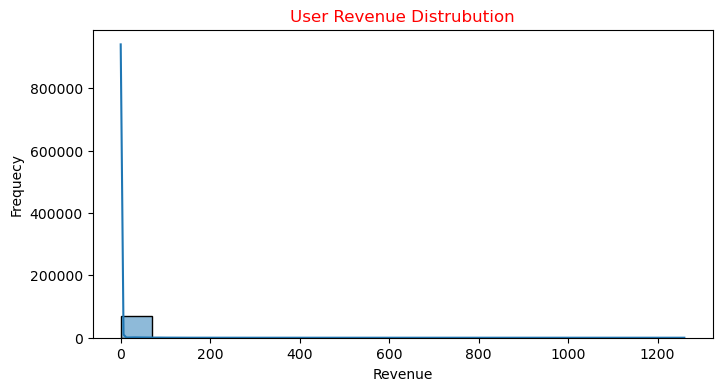

In [22]:
plt.figure(figsize= [8,4])
sns.histplot(data =merged_df['itemRevenue90'] , kde = True)
plt.title("User Revenue Distrubution", color = 'r')
plt.xlabel("Revenue")
plt.ylabel("Frequecy")
plt.show()

C:\Users\w11\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


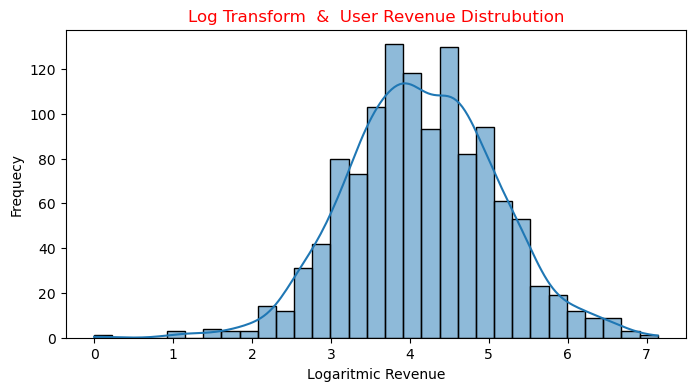

In [23]:
plt.figure(figsize= [8,4])
sns.histplot(data = np.log(merged_df['itemRevenue90']) , kde = True)
plt.title("Log Transform  &  User Revenue Distrubution", color = 'r')
plt.xlabel("Logaritmic Revenue")
plt.ylabel("Frequecy")
plt.show()

C:\Users\w11\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\w11\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


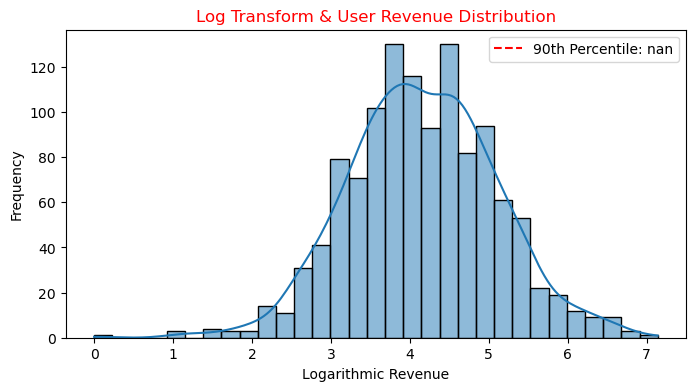

In [117]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Verinin logaritmik dönüşümünü yapın
log_data = np.log(merged_df['itemRevenue90'])

# Yüzde 90'lık yüzdelik dilimi hesaplayın
threshold_90 = np.percentile(log_data, 10)

# Histogram ve KDE grafiğini çizin
plt.figure(figsize=[8,4])
sns.histplot(data=log_data, kde=True)
plt.axvline(threshold_90, color='r', linestyle='--', label=f'90th Percentile: {threshold_90:.2f}')
plt.title("Log Transform & User Revenue Distribution", color='r')
plt.xlabel("Logarithmic Revenue")
plt.ylabel("Frequency")
plt.legend()
plt.show()


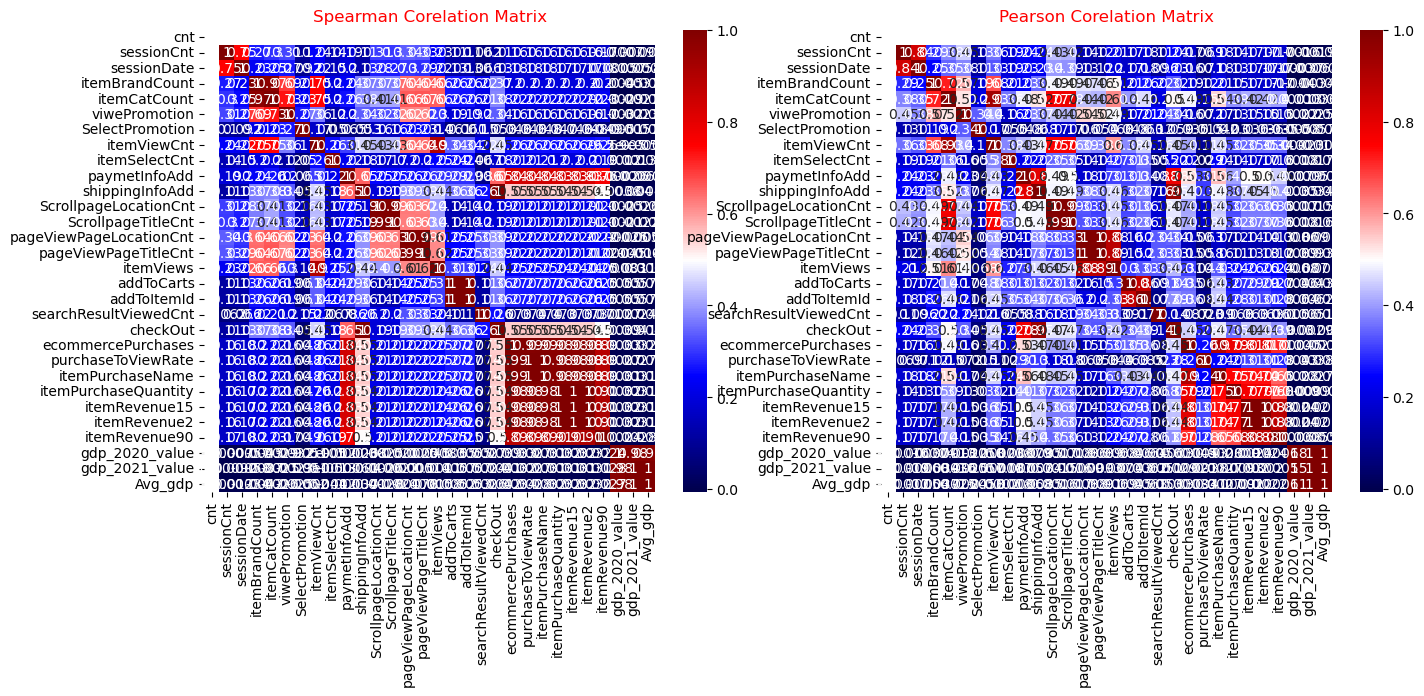

In [24]:
merged_num = merged_df.select_dtypes(include = 'number')

plt.figure(figsize=[16,6])

plt.subplot(1,2,1)
sns.heatmap(merged_num.corr(method = 'spearman'), cmap="seismic", annot=True)
plt.title('Spearman Corelation Matrix', color = 'red')


plt.subplot(1,2,2)
sns.heatmap(merged_num.corr(method = 'pearson'), cmap="seismic", annot=True)
plt.title('Pearson Corelation Matrix', color = 'red')
plt.show()

In [25]:
merged_df.dropna(inplace = True)
merged_df.isnull().sum()

user_pseudo_id             0
medium                     0
name                       0
source                     0
mobile_brand_name          0
country                    0
category                   0
cnt                        0
fdate                      0
sessionCnt                 0
sessionDate                0
itemBrandCount             0
itemCatCount               0
viwePromotion              0
SelectPromotion            0
itemViewCnt                0
itemSelectCnt              0
paymetInfoAdd              0
shippingInfoAdd            0
ScrollpageLocationCnt      0
ScrollpageTitleCnt         0
pageViewPageLocationCnt    0
pageViewPageTitleCnt       0
itemViews                  0
addToCarts                 0
addToItemId                0
searchResultViewedCnt      0
checkOut                   0
ecommercePurchases         0
purchaseToViewRate         0
itemPurchaseName           0
itemPurchaseQuantity       0
itemRevenue15              0
itemRevenue2               0
itemRevenue90 

In [26]:
merged_df.describe()

,cnt,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,gdp_2020_value,gdp_2021_value,Avg_gdp
count,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.0,71143.000000,71143.0,71143.0,71143.000000,71143.000000,71143.000000,71143.000000,71143.000000,71143.000000
mean,1.0,1.326694,1.157289,0.631362,0.872384,0.79738,0.036265,3.887185,0.214722,0.047285,0.080373,1.413547,1.365208,3.728884,3.586481,1.719818,0.100403,0.486274,0.107853,0.105407,0.058361,0.300193,0.046765,0.083002,1.327186,1.327186,1.667543,43417.235547,48731.240880,46074.238213
std,0.0,0.87589,0.524269,0.852065,1.77226,1.384187,0.221692,10.403336,2.124363,0.436695,0.481802,2.524692,2.406327,10.238559,10.127928,7.229412,1.113576,3.919526,0.682573,0.687754,0.718942,4.441209,0.519197,1.277185,17.009719,17.009719,19.652619,24345.286920,27033.589439,25669.639554
min,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1139.192000,1229.470000,1184.331000
25%,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,22984.459000,26794.625000,24889.542000
50%,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,49168.162000,53696.159000,51389.159500
75%,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,64367.435000,70995.794000,67681.614500
max,1.0,12.0,12.0,5.0,31.0,25.0,6.0,197.0,100.0,28.0,20.0,52.0,49.0,128.0,98.0,198.0,69.0,132.0,59.0,28.0,60.0,200.000000,26.0,110.0,973.000000,973.000000,1260.000000,117616.151000,134925.351000,126270.751000


In [27]:
int_columns = merged_num.select_dtypes(include=['int64', 'int32']).columns
merged_num[int_columns] = merged_num[int_columns].astype('float64')
merged_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71738 entries, 0 to 71737
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cnt                      71738 non-null  float64
 1   sessionCnt               71738 non-null  float64
 2   sessionDate              71738 non-null  float64
 3   itemBrandCount           71738 non-null  float64
 4   itemCatCount             71738 non-null  float64
 5   viwePromotion            71738 non-null  float64
 6   SelectPromotion          71738 non-null  float64
 7   itemViewCnt              71738 non-null  float64
 8   itemSelectCnt            71738 non-null  float64
 9   paymetInfoAdd            71738 non-null  float64
 10  shippingInfoAdd          71738 non-null  float64
 11  ScrollpageLocationCnt    71738 non-null  float64
 12  ScrollpageTitleCnt       71738 non-null  float64
 13  pageViewPageLocationCnt  71738 non-null  float64
 14  pageViewPageTitleCnt  

In [28]:
merged_num['itemRevenue90'] = merged_num['itemRevenue90'].apply(lambda x: x if x > 0 else 1e-10)
merged_num['LogLtv90'] = np.log(merged_num['itemRevenue90'])
merged_num['LogGDP'] = np.log(merged_num['Avg_gdp'])

In [29]:
# Değişkenlerin tanımlaması
y, X = patsy.dmatrices('LogLtv90 ~ sessionCnt + sessionDate + itemBrandCount + itemCatCount + viwePromotion + SelectPromotion + itemViewCnt + itemSelectCnt + paymetInfoAdd + shippingInfoAdd + ScrollpageLocationCnt + pageViewPageLocationCnt + pageViewPageTitleCnt + itemViews + addToCarts + addToItemId + searchResultViewedCnt + checkOut + ecommercePurchases +  itemPurchaseName + LogGDP + gdp_2020_value + gdp_2021_value  ', data=merged_num, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               LogLtv90   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     4298.
Date:                Sat, 11 May 2024   Prob (F-statistic):               0.00
Time:                        12:44:34   Log-Likelihood:            -1.5905e+05
No. Observations:               71143   AIC:                         3.181e+05
Df Residuals:                   71119   BIC:                         3.184e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -23.5373      0.172   -136.448      0.000     -23.875     -23.199
sessionCnt                 -0.0844      0.019     -4.501      0.000      -0.121      -0.048
sessionDate                 0.2913      0.030      9.759      0.000       0.233       0.350
itemBrandCount              0.1681      0.017     10.149      0.000       0.136       0.201
itemCatCount                0.3672      0.017     21.206      0.000       0.333       0.401
viwePromotion              -0.1899      0.010    -18.903      0.000      -0.210      -0.170
SelectPromotion            -0.0210      0.042     -0.504      0.614      -0.103       0.061
itemViewCnt                -0.0500      0.003    -18.490      0.000      -0.055      -0.045
itemSelectCnt               0.0044      0.004      0.983      0.326      -0.004       0.013
paymetInfoAdd               1.9154      0.036     52.673      0.000       1.844       1.987
shippingInfoAdd             0.4129      0.059      6.970      0.000       0.297       0.529
ScrollpageLocationCnt       0.1969      0.006     32.944      0.000       0.185       0.209
pageViewPageLocationCnt     0.0046      0.010      0.463      0.643      -0.015       0.024
pageViewPageTitleCnt        0.0418      0.010      4.155      0.000       0.022       0.062
itemViews                  -0.0846      0.004    -23.855      0.000      -0.092      -0.078
addToCarts                 -0.0539      0.015     -3.476      0.001      -0.084      -0.023
addToItemId                -0.0271      0.005     -5.933      0.000      -0.036      -0.018
searchResultViewedCnt       0.0114      0.013      0.846      0.397      -0.015       0.038
checkOut                    0.1207      0.039      3.131      0.002       0.045       0.196
ecommercePurchases         -0.1823      0.028     -6.513      0.000      -0.237      -0.127
itemPurchaseName            3.4533      0.042     82.317      0.000       3.371       3.536
LogGDP                      0.0100      0.020      0.488      0.625      -0.030       0.050
gdp_2020_value          -5.398e-06   4.44e-06     -1.215      0.224   -1.41e-05    3.31e-06
gdp_2021_value           4.609e-06   4.13e-06      1.117      0.264   -3.48e-06    1.27e-05
==============================================================================
Omnibus:                    75420.372   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         44260536.249
Skew:                           4.592   Prob(JB):                         0.00
Kurtosis:                     124.848   Cond. No.                     1.53e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number 

In [30]:
country_filtered = merged_df[merged_df['country'].isin(["United States", "Canada", "Germany", "India", "France", "Taiwan",'Italy', "Japan","Spain", "China", "Singapore", "South Korea", "Netherlands", 'Turkey'])]

In [31]:
country_filtered.loc[:, 'itemRevenue90'] = country_filtered['itemRevenue90'].apply(lambda x: x if x > 0 else 1e-10)
country_filtered.loc[:, 'LogLtv90'] = np.log(country_filtered['itemRevenue90'])
country_filtered.loc[:, 'LogGDP'] = np.log(country_filtered['Avg_gdp'])

C:\Users\w11\AppData\Local\Temp\ipykernel_9128\1260032352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_filtered.loc[:, 'LogLtv90'] = np.log(country_filtered['itemRevenue90'])
C:\Users\w11\AppData\Local\Temp\ipykernel_9128\1260032352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_filtered.loc[:, 'LogGDP'] = np.log(country_filtered['Avg_gdp'])


In [32]:
country_filtered.head(12)

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,gdp_2020_value,gdp_2021_value,Avg_gdp,LogLtv90,LogGDP
0,10127595.0074517656,(none),(direct),(direct),<Other>,Italy,mobile,1,2020-11-27,2,1,4,4,3,0,33,0,0,0,4,3,13,11,5,1,12,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,31788.997,36401.883,34095.4400,-23.025851,10.436919
1,10173883.8536111015,referral,(referral),shop.googlemerchandisestore.com,Apple,United States,desktop,1,2020-11-03,4,3,2,1,0,0,11,0,0,0,2,2,2,2,1,0,0,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,64367.435,70995.794,67681.6145,-23.025851,11.122570
2,10293790.7574745821,organic,(organic),google,Apple,United States,mobile,1,2020-11-30,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,64367.435,70995.794,67681.6145,-23.025851,11.122570
4,10579511.7188934316,(none),(direct),(direct),Google,France,mobile,1,2020-11-18,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,40529.093,45161.226,42845.1595,-23.025851,10.665348
5,10638613.8798060664,(none),(direct),(direct),Apple,India,desktop,1,2020-11-16,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,1915.552,2250.179,2082.8655,-23.025851,7.641500
6,1065430.0447620787,organic,(organic),google,Apple,United States,mobile,1,2020-11-26,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,64367.435,70995.794,67681.6145,-23.025851,11.122570
7,10698305.5290863860,organic,(organic),google,Google,United States,desktop,1,2020-11-30,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,64367.435,70995.794,67681.6145,-23.025851,11.122570
8,1085998.0997499971,organic,(organic),<Other>,Google,United States,desktop,1,2020-11-04,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,64367.435,70995.794,67681.6145,-23.025851,11.122570
10,1092760.4674510258,(none),(direct),(direct),Apple,France,desktop,1,2020-11-04,1,1,0,0,0,0,0,0,0,0,1,1,2,2,0,0,0,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,40529.093,45161.226,42845.1595,-23.025851,10.665348
11,1093078.8654828434,(none),(direct),(direct),Apple,Taiwan,mobile,1,2020-11-09,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,28571.440,33070.701,30821.0705,-23.025851,10.335954


In [33]:
merged_num.corr()['itemRevenue90']

cnt                             NaN
sessionCnt                 0.172866
sessionDate                0.168149
itemBrandCount             0.171861
itemCatCount               0.402323
viwePromotion              0.146255
SelectPromotion            0.034928
itemViewCnt                0.343486
itemSelectCnt              0.162529
paymetInfoAdd              0.446948
shippingInfoAdd            0.400674
ScrollpageLocationCnt      0.349895
ScrollpageTitleCnt         0.355725
pageViewPageLocationCnt    0.130645
pageViewPageTitleCnt       0.124394
itemViews                  0.244604
addToCarts                 0.268798
addToItemId                0.280878
searchResultViewedCnt      0.061385
checkOut                   0.388878
ecommercePurchases         0.712584
purchaseToViewRate         0.279341
itemPurchaseName           0.652839
itemPurchaseQuantity       0.680966
itemRevenue15              0.879095
itemRevenue2               0.879095
itemRevenue90              1.000000
gdp_2020_value             0

In [34]:
dummies_df = pd.get_dummies(country_filtered[['medium', 'mobile_brand_name', 'country', 'category']], drop_first=True, dtype=int)

In [35]:
dummy_df = pd.concat([country_filtered,dummies_df], axis = 1)
dummy_df.head()

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,gdp_2020_value,gdp_2021_value,Avg_gdp,LogLtv90,LogGDP,medium_(none),medium_<Other>,medium_cpc,medium_organic,medium_referral,mobile_brand_name_Apple,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,category_mobile,category_tablet
0,10127595.0074517656,(none),(direct),(direct),<Other>,Italy,mobile,1,2020-11-27,2,1,4,4,3,0,33,0,0,0,4,3,13,11,5,1,12,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,31788.997,36401.883,34095.4400,-23.025851,10.436919,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,10173883.8536111015,referral,(referral),shop.googlemerchandisestore.com,Apple,United States,desktop,1,2020-11-03,4,3,2,1,0,0,11,0,0,0,2,2,2,2,1,0,0,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,64367.435,70995.794,67681.6145,-23.025851,11.122570,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,10293790.7574745821,organic,(organic),google,Apple,United States,mobile,1,2020-11-30,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,64367.435,70995.794,67681.6145,-23.025851,11.122570,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,10579511.7188934316,(none),(direct),(direct),Google,France,mobile,1,2020-11-18,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,40529.093,45161.226,42845.1595,-23.025851,10.665348,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
5,10638613.8798060664,(none),(direct),(direct),Apple,India,desktop,1,2020-11-16,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,1.000000e-10,1915.552,2250.179,2082.8655,-23.025851,7.641500,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [36]:
x = dummy_df.drop(['itemRevenue2','itemRevenue90', 'LogLtv90', 'user_pseudo_id','medium','name','source','mobile_brand_name','country','category','cnt','fdate'], axis = 1)
y = (dummy_df.LogLtv90)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [38]:
X_train.columns

Index(['sessionCnt', 'sessionDate', 'itemBrandCount', 'itemCatCount',
       'viwePromotion', 'SelectPromotion', 'itemViewCnt', 'itemSelectCnt',
       'paymetInfoAdd', 'shippingInfoAdd', 'ScrollpageLocationCnt',
       'ScrollpageTitleCnt', 'pageViewPageLocationCnt', 'pageViewPageTitleCnt',
       'itemViews', 'addToCarts', 'addToItemId', 'searchResultViewedCnt',
       'checkOut', 'ecommercePurchases', 'purchaseToViewRate',
       'itemPurchaseName', 'itemPurchaseQuantity', 'itemRevenue15',
       'gdp_2020_value', 'gdp_2021_value', 'Avg_gdp', 'LogGDP',
       'medium_(none)', 'medium_<Other>', 'medium_cpc', 'medium_organic',
       'medium_referral', 'mobile_brand_name_Apple',
       'mobile_brand_name_Google', 'mobile_brand_name_Huawei',
       'mobile_brand_name_Microsoft', 'mobile_brand_name_Mozilla',
       'mobile_brand_name_Samsung', 'mobile_brand_name_Xiaomi',
       'country_China', 'country_France', 'country_Germany', 'country_India',
       'country_Italy', 'country_Japan'

## Linear Regression

In [39]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

test_score = lr_model.score(X_test, y_test)
y_pred = lr_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
Train_score = r2_score(y_train, lr_model.predict(X_train))


print('Test R2 Score:', round(test_score,3))
print(f"Train R² Score: {Train_score:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")

Test R2 Score: 0.657
Train R² Score: 0.670
Mean Absolute Error: 0.503
Mean Squared Error: 4.508
Root Mean Squared Error: 2.123


## Random Forest Regressor

In [40]:
# Modeli başlatma ve eğitme
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 ağaç kullanıyoruz
rf_model.fit(X_train, y_train)

# Test seti üzerinde tahmin yapma
y_pred_rf = rf_model.predict(X_test)

# Performans metriklerini hesaplama
test_score_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"Test R2 Score: {test_score_rf:.3f}")
print(f"Mean Squared Error: {mse_rf:.3f}")
print(f"Root Mean Squared Error: {rmse_rf:.3f}")

Test R2 Score: 0.794
Mean Squared Error: 2.711
Root Mean Squared Error: 1.646


In [41]:
R2_Score_cv = cross_val_score(rf_model, x, y , cv = 3, scoring = 'r2')
print("R2 Scores: ", R2_Score_cv)
print("Average R2 Scores: ", np.mean(R2_Score_cv))

R2 Scores:  [0.78824164 0.78322781 0.83756146]
Average R2 Scores:  0.8030103041374071


In [42]:
param_grid = {
    'n_estimators': [20 ,100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Modeli başlat
rf_gs = RandomForestRegressor(random_state=42)

# GridSearchCV objesini başlat
grid_search = GridSearchCV(estimator=rf_gs, param_grid=param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)

# Grid search'ı fit et
grid_search.fit(X_train, y_train)

# Best params & Best Score
print("Best parameters:", grid_search.best_params_)
print("Best score R2:", -grid_search.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Best score R2: -0.8403719788703341


In [43]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=10,
                      n_estimators=500, random_state=42)

In [44]:
x = dummy_df.drop(['itemRevenue2','itemRevenue90', 'LogLtv90', 'user_pseudo_id','medium','name','source','mobile_brand_name','country','category','cnt','fdate'], axis = 1)
y =(dummy_df.LogLtv90)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [46]:
X_train.head()

,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,gdp_2020_value,gdp_2021_value,Avg_gdp,LogGDP,medium_(none),medium_<Other>,medium_cpc,medium_organic,medium_referral,mobile_brand_name_Apple,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,category_mobile,category_tablet
41128,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,1915.552,2250.179,2082.8655,7.641500,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
11233,2,1,1,3,2,0,12,0,0,0,2,2,5,5,1,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
53479,1,1,2,1,0,0,12,0,0,0,0,0,2,2,1,0,0,0,0,0,0.0,0,0,0.0,31788.997,36401.883,34095.4400,10.436919,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
49126,3,3,2,1,0,0,5,5,0,0,5,5,6,6,2,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
62811,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,43573.195,52520.512,48046.8535,10.779932,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
# Modeli başlatma ve eğitme
##rf_model_best = RandomForestRegressor(n_estimators=200, random_state=42, max_features = 'sqrt' ,  min_samples_split=5, max_depth=10, min_samples_leaf=2) 
best_params = grid_search.best_params_
rf_model_best = RandomForestRegressor(**best_params)
rf_model_best.fit(X_train, y_train)

# Test seti üzerinde tahmin yapma
y_pred_rfb = rf_model_best.predict(X_test)

# Performans metriklerini hesaplama
test_score_rfb = r2_score(y_test, y_pred_rfb)
mse_rfb = mean_squared_error(y_test, y_pred_rfb)
rmse_rfb = np.sqrt(mse_rfb)

print(f"Test R2 Score: {test_score_rfb:.3f}")
print(f"Mean Squared Error: {mse_rfb:.3f}")
print(f"Root Mean Squared Error: {rmse_rfb:.3f}")

Test R2 Score: 0.813
Mean Squared Error: 2.453
Root Mean Squared Error: 1.566


In [48]:
int_columns_dummy_df = dummy_df.select_dtypes(include=['int64', 'int32']).columns
dummy_df[int_columns_dummy_df] = dummy_df[int_columns_dummy_df].astype('float64')
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55363 entries, 0 to 71737
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   user_pseudo_id               55363 non-null  object 
 1   medium                       55363 non-null  object 
 2   name                         55363 non-null  object 
 3   source                       55363 non-null  object 
 4   mobile_brand_name            55363 non-null  object 
 5   country                      55363 non-null  object 
 6   category                     55363 non-null  object 
 7   cnt                          55363 non-null  float64
 8   fdate                        55363 non-null  dbdate 
 9   sessionCnt                   55363 non-null  float64
 10  sessionDate                  55363 non-null  float64
 11  itemBrandCount               55363 non-null  float64
 12  itemCatCount                 55363 non-null  float64
 13  viwePromotion        

In [49]:
stat_df = dummy_df.drop(['itemRevenue2', 'itemRevenue90', 'user_pseudo_id','medium','name','source','mobile_brand_name','country','category','cnt','fdate'], axis = 1)

In [50]:
# Değişkenlerin tanımlaması
y, X = patsy.dmatrices('LogLtv90 ~ sessionCnt + itemRevenue15 + sessionDate +itemBrandCount +itemCatCount +viwePromotion +SelectPromotion +itemViewCnt +itemSelectCnt +paymetInfoAdd +shippingInfoAdd +ScrollpageLocationCnt +ScrollpageTitleCnt +pageViewPageLocationCnt +pageViewPageTitleCnt +itemViews +addToCarts +addToItemId +searchResultViewedCnt +checkOut +ecommercePurchases +purchaseToViewRate +itemPurchaseName +itemPurchaseQuantity +gdp_2020_value + gdp_2021_value +Avg_gdp +LogGDP +medium_none +medium_Other +medium_cpc +medium_organic +medium_referral +mobile_brand_name_Apple +mobile_brand_name_Google +mobile_brand_name_Huawei +mobile_brand_name_Microsoft +mobile_brand_name_Mozilla +mobile_brand_name_Samsung +mobile_brand_name_Xiaomi +country_China +country_France +country_Germany +country_India +country_Italy +country_Japan +country_Netherlands +country_Singapore +country_South_Korea +country_Spain +country_Taiwan +country_Turkey +country_United_States +category_mobile +category_tablet ', data= stat_df, return_type="dataframe")

# Modeli Oluşturma
StatModel = sm.OLS(y, X)

# Modeli Eğitme
fit = StatModel.fit()

# Oluşturduğumuz modele ilişkin özet tablosunu görüntüleme
fit.summary()

PatsyError: Error evaluating factor: NameError: name 'medium_Other' is not defined
    LogLtv90 ~ sessionCnt + itemRevenue15 + sessionDate +itemBrandCount +itemCatCount +viwePromotion +SelectPromotion +itemViewCnt +itemSelectCnt +paymetInfoAdd +shippingInfoAdd +ScrollpageLocationCnt +ScrollpageTitleCnt +pageViewPageLocationCnt +pageViewPageTitleCnt +itemViews +addToCarts +addToItemId +searchResultViewedCnt +checkOut +ecommercePurchases +purchaseToViewRate +itemPurchaseName +itemPurchaseQuantity +gdp_2020_value + gdp_2021_value +Avg_gdp +LogGDP +medium_none +medium_Other +medium_cpc +medium_organic +medium_referral +mobile_brand_name_Apple +mobile_brand_name_Google +mobile_brand_name_Huawei +mobile_brand_name_Microsoft +mobile_brand_name_Mozilla +mobile_brand_name_Samsung +mobile_brand_name_Xiaomi +country_China +country_France +country_Germany +country_India +country_Italy +country_Japan +country_Netherlands +country_Singapore +country_South_Korea +country_Spain +country_Taiwan +country_Turkey +country_United_States +category_mobile +category_tablet
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ^^^^^^^^^^^^

In [51]:
## Find Best Alpha Value for Best R2
from sklearn.pipeline import Pipeline

alphalist = np.linspace(0.1,500,100) # Daha geniş aralıkta inceleme yapmak için np.linspace() parametrelerini değiştirin
err_vec_val = []

for curr_alpha in alphalist:

    # Her bir döngüde ilk olarak Scaling uygula ve sonrasında belirtilen alpha değerinde Lasso'yu çalıştır
    steps = [('scaling', StandardScaler()),
             ('Ridge', Ridge(alpha = curr_alpha, tol=0.1))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)

    val_set_pred = pipe.predict(X_test)
    err_vec_val.append(r2_score(y_test, val_set_pred))

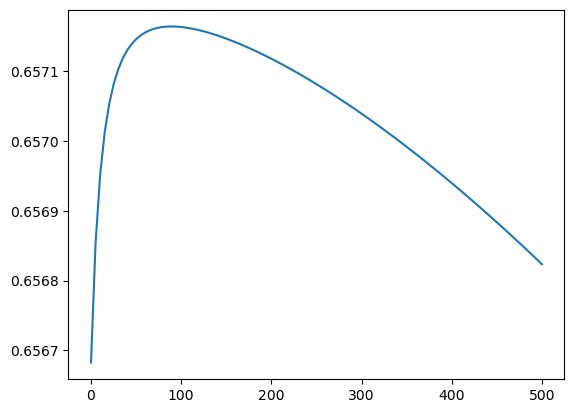

In [52]:
plt.plot(alphalist, err_vec_val);

In [53]:
np.max(err_vec_val) # Lasso kullanarak ulaşabildiğimiz maximum R2

0.6571636713719431

In [54]:
alphalist[np.argmax(err_vec_val)]

90.99090909090908

In [55]:
std_scale = StandardScaler()

In [56]:
column_names = X_train.columns
X_ss = std_scale.fit_transform(X_train)
x_ss_test = std_scale.fit_transform(X_test)


In [57]:
X_ss = pd.DataFrame(X_ss, columns= column_names)

In [58]:
X_ss.head()

,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,gdp_2020_value,gdp_2021_value,Avg_gdp,LogGDP,medium_(none),medium_<Other>,medium_cpc,medium_organic,medium_referral,mobile_brand_name_Apple,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,category_mobile,category_tablet
0,-0.376924,-0.301941,-0.741454,-0.489636,-0.575736,-0.165786,-0.374547,-0.102794,-0.106038,-0.165904,-0.165080,-0.153357,-0.266335,-0.255496,-0.238318,-0.09596,-0.126152,-0.151148,-0.152327,-0.078613,-0.066199,-0.088667,-0.065236,-0.077459,-2.091249,-2.114753,-2.105419,-2.538073,-0.558382,-0.470126,-0.239834,1.265069,-0.406849,-0.857574,-0.731343,-0.124591,-0.159813,-0.119736,3.565995,-0.154303,-0.150503,-0.16166,-0.158096,2.704198,-0.140302,-0.135715,-0.120124,-0.130711,-0.12709,-0.159292,-0.145808,-0.114688,-1.149945,1.225379,-0.151442
1,0.780369,-0.301941,0.429778,1.188066,0.867678,-0.165786,0.775103,-0.102794,-0.106038,-0.165904,0.231159,0.263034,0.119482,0.133970,-0.101569,-0.09596,-0.126152,-0.151148,-0.152327,-0.078613,-0.066199,-0.088667,-0.065236,-0.077459,0.716020,0.687774,0.701823,0.538882,1.790887,-0.470126,-0.239834,-0.790471,-0.406849,-0.857574,1.367347,-0.124591,-0.159813,-0.119736,-0.280427,-0.154303,-0.150503,-0.16166,-0.158096,-0.369795,-0.140302,-0.135715,-0.120124,-0.130711,-0.12709,-0.159292,-0.145808,-0.114688,0.869607,-0.816074,-0.151442
2,-0.376924,-0.301941,1.601010,0.069598,-0.575736,-0.165786,0.775103,-0.102794,-0.106038,-0.165904,-0.561319,-0.569748,-0.169881,-0.158130,-0.101569,-0.09596,-0.126152,-0.151148,-0.152327,-0.078613,-0.066199,-0.088667,-0.065236,-0.077459,-0.748410,-0.722503,-0.735469,-0.067172,-0.558382,-0.470126,-0.239834,1.265069,-0.406849,1.166080,-0.731343,-0.124591,-0.159813,-0.119736,-0.280427,-0.154303,-0.150503,-0.16166,-0.158096,-0.369795,7.127494,-0.135715,-0.120124,-0.130711,-0.12709,-0.159292,-0.145808,-0.114688,-1.149945,-0.816074,-0.151442
3,1.937662,3.586677,1.601010,0.069598,-0.575736,-0.165786,0.104474,2.199819,-0.106038,-0.165904,1.419875,1.512207,0.215936,0.231336,0.035180,-0.09596,-0.126152,-0.151148,-0.152327,-0.078613,-0.066199,-0.088667,-0.065236,-0.077459,0.716020,0.687774,0.701823,0.538882,-0.558382,2.127090,-0.239834,-0.790471,-0.406849,-0.857574,-0.731343,-0.124591,-0.159813,-0.119736,-0.280427,-0.154303,-0.150503,-0.16166,-0.158096,-0.369795,-0.140302,-0.135715,-0.120124,-0.130711,-0.12709,-0.159292,-0.145808,-0.114688,0.869607,1.225379,-0.151442
4,-0.376924,-0.301941,-0.741454,-0.489636,-0.575736,-0.165786,-0.374547,-0.102794,-0.106038,-0.165904,-0.165080,-0.153357,-0.266335,-0.255496,-0.238318,-0.09596,-0.126152,-0.151148,-0.152327,-0.078613,-0.066199,-0.088667,-0.065236,-0.077459,-0.218700,-0.065401,-0.138430,0.236021,1.790887,-0.470126,-0.239834,-0.790471,-0.406849,-0.857574,1.367347,-0.124591,-0.159813,-0.119736,-0.280427,-0.154303,-0.150503,-0.16166,-0.158096,-0.369795,-0.140302,-0.135715,-0.120124,-0.130711,-0.12709,-0.159292,-0.145808,-0.114688,-1.149945,-0.816074,-0.151442


In [59]:
ridge_model_ss = Ridge(alpha = alphalist[np.argmax(err_vec_val)])
ridge_model_ss.fit(X_ss, y_train)
list(zip(X_train.columns, ridge_model_ss.coef_))

[('sessionCnt', -0.058723511320417525),
 ('sessionDate', 0.10378221132627288),
 ('itemBrandCount', -0.0003435857791558851),
 ('itemCatCount', 0.6158117148542512),
 ('viwePromotion', -0.1384333809707118),
 ('SelectPromotion', -0.03309804987838201),
 ('itemViewCnt', -0.3572004765623052),
 ('itemSelectCnt', 0.007901404937600914),
 ('paymetInfoAdd', 0.5741155098980993),
 ('shippingInfoAdd', -0.11798002262982295),
 ('ScrollpageLocationCnt', -0.06163678456057629),
 ('ScrollpageTitleCnt', 0.4734629960316066),
 ('pageViewPageLocationCnt', 0.1881146707763499),
 ('pageViewPageTitleCnt', -0.033089070825922974),
 ('itemViews', -0.20105533570104991),
 ('addToCarts', -0.017391171662055827),
 ('addToItemId', -0.15085201561734063),
 ('searchResultViewedCnt', 0.0013170208285779228),
 ('checkOut', 0.2836692157476576),
 ('ecommercePurchases', -0.513723609318097),
 ('purchaseToViewRate', 1.0215772187400518),
 ('itemPurchaseName', 1.7774825964966903),
 ('itemPurchaseQuantity', -0.43037537266807646),
 ('ite

In [60]:
ridge_model_ss.score(X_ss, y_train)

0.6695366910066533

In [61]:
merged_df.head()

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,gdp_2020_value,gdp_2021_value,Avg_gdp
0,10127595.0074517656,(none),(direct),(direct),<Other>,Italy,mobile,1,2020-11-27,2,1,4,4,3,0,33,0,0,0,4,3,13,11,5,1,12,0,0,0,0.0,0,0,0.0,0.0,0.0,31788.997,36401.883,34095.4400
1,10173883.8536111015,referral,(referral),shop.googlemerchandisestore.com,Apple,United States,desktop,1,2020-11-03,4,3,2,1,0,0,11,0,0,0,2,2,2,2,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145
2,10293790.7574745821,organic,(organic),google,Apple,United States,mobile,1,2020-11-30,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145
3,1046525.9187222355,referral,(referral),<Other>,Google,Philippines,desktop,1,2020-11-07,1,1,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,3325.836,3576.110,3450.9730
4,10579511.7188934316,(none),(direct),(direct),Google,France,mobile,1,2020-11-18,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,40529.093,45161.226,42845.1595


In [62]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71143 entries, 0 to 71737
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_pseudo_id           71143 non-null  object 
 1   medium                   71143 non-null  object 
 2   name                     71143 non-null  object 
 3   source                   71143 non-null  object 
 4   mobile_brand_name        71143 non-null  object 
 5   country                  71143 non-null  object 
 6   category                 71143 non-null  object 
 7   cnt                      71143 non-null  Int64  
 8   fdate                    71143 non-null  dbdate 
 9   sessionCnt               71143 non-null  Int64  
 10  sessionDate              71143 non-null  Int64  
 11  itemBrandCount           71143 non-null  Int64  
 12  itemCatCount             71143 non-null  Int64  
 13  viwePromotion            71143 non-null  Int64  
 14  SelectPromotion          71

In [63]:
merged_df['itemRevenue90'].mean()

1.667542836259365

In [64]:
pd.set_option('display.max_rows', None)

In [65]:
merged_df['itemRevenue90'].value_counts(normalize= True)

itemRevenue90
0.0       0.983175
30.0      0.000436
48.0      0.000365
32.0      0.000351
44.0      0.000337
38.0      0.000309
24.0      0.000295
55.0      0.000267
92.0      0.000253
60.0      0.000239
40.0      0.000225
20.0      0.000211
22.0      0.000211
34.0      0.000197
14.0      0.000197
16.0      0.000197
18.0      0.000197
46.0      0.000183
96.0      0.000183
13.0      0.000183
71.0      0.000183
56.0      0.000183
88.0      0.000183
41.0      0.000169
50.0      0.000169
25.0      0.000155
21.0      0.000155
36.0      0.000155
100.0     0.000155
98.0      0.000141
37.0      0.000141
35.0      0.000141
63.0      0.000141
27.0      0.000127
29.0      0.000127
12.0      0.000127
54.0      0.000127
28.0      0.000112
42.0      0.000112
62.0      0.000112
10.0      0.000112
58.0      0.000112
87.0      0.000112
26.0      0.000112
19.0      0.000112
52.0      0.000112
111.0     0.000112
108.0     0.000098
33.0      0.000098
126.0     0.000098
94.0      0.000098
80.0      0.00009

## Random forest için tahminler

In [66]:
rf_pred = pd.DataFrame(rf_model.predict(X_test), columns = ['rf_pred'])
y_test_df = pd.DataFrame(y_test).reset_index(drop = True)
rf_comb = pd.concat([rf_pred,y_test_df], axis = 1)
rf_comb['rf_pred'] = np.exp(rf_comb['rf_pred'] )
rf_comb['Ltv90'] = np.exp(rf_comb['LogLtv90'] )
pd.set_option('display.float_format', lambda x: '%.4f' % x)
rf_comb.sample(9)

,rf_pred,LogLtv90,Ltv90
6160,0.0000,-23.0259,0.0000
114,0.0000,-23.0259,0.0000
7947,0.0000,-23.0259,0.0000
5793,0.0000,-23.0259,0.0000
3011,0.0000,-23.0259,0.0000
7724,0.0000,-23.0259,0.0000
3218,0.0000,-23.0259,0.0000
4114,0.0000,-23.0259,0.0000
1816,0.0000,-23.0259,0.0000


In [67]:
X_train.head()

,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,gdp_2020_value,gdp_2021_value,Avg_gdp,LogGDP,medium_(none),medium_<Other>,medium_cpc,medium_organic,medium_referral,mobile_brand_name_Apple,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,category_mobile,category_tablet
41128,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0000,0,0,0.0000,1915.5520,2250.1790,2082.8655,7.6415,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
11233,2,1,1,3,2,0,12,0,0,0,2,2,5,5,1,0,0,0,0,0,0.0000,0,0,0.0000,64367.4350,70995.7940,67681.6145,11.1226,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
53479,1,1,2,1,0,0,12,0,0,0,0,0,2,2,1,0,0,0,0,0,0.0000,0,0,0.0000,31788.9970,36401.8830,34095.4400,10.4369,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
49126,3,3,2,1,0,0,5,5,0,0,5,5,6,6,2,0,0,0,0,0,0.0000,0,0,0.0000,64367.4350,70995.7940,67681.6145,11.1226,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
62811,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0000,0,0,0.0000,43573.1950,52520.5120,48046.8535,10.7799,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


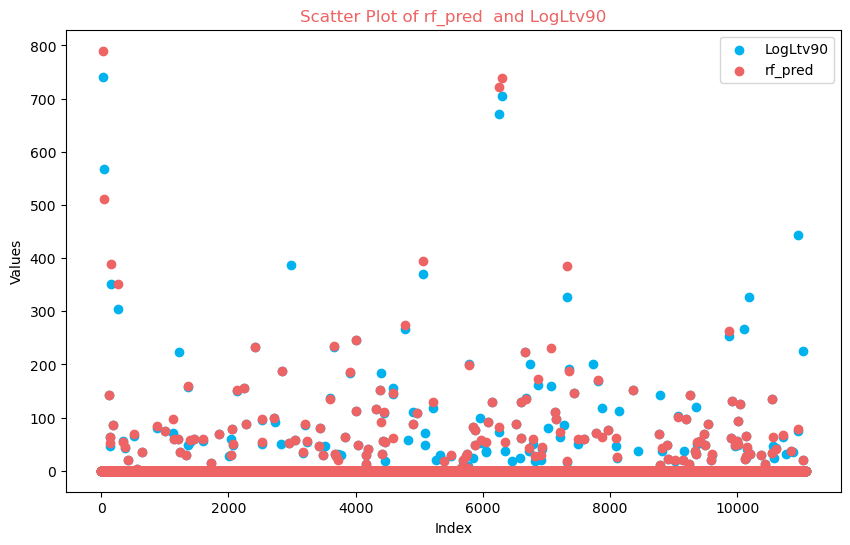

In [68]:
plt.figure(figsize=(10, 6))
plt.scatter(rf_comb.index, rf_comb['Ltv90'],color='#00b2ee', label='LogLtv90')
plt.scatter(rf_comb.index, rf_comb['rf_pred'], color='#ee6363', label='rf_pred')
plt.title('Scatter Plot of rf_pred  and LogLtv90', color = '#ee6363')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

In [69]:
## n_estimator = 100 & Random Forest Regressor Pred & Actual Comparsion
rf_comb[rf_comb['rf_pred']>1]

,rf_pred,LogLtv90,Ltv90
32,790.0763,6.6067,740.0000
52,510.4110,6.3421,568.0000
120,142.3067,4.9558,142.0000
138,52.0607,3.8286,46.0000
139,64.2636,4.1431,63.0000
153,389.6771,5.8636,352.0000
186,85.1784,4.4543,86.0000
267,351.4367,5.7203,305.0000
348,54.9277,4.0073,55.0000
368,43.7158,3.7377,42.0000


In [70]:
## Comparsion of predicted & Actual LTV90 for Best Model founded after GridSearchCv
rf_best_pred = pd.DataFrame(rf_model_best.predict(X_test), columns = ['rf_best_pred'])
y_test_df = pd.DataFrame(y_test).reset_index(drop = True)
rf_best_comb = pd.concat([rf_best_pred,y_test_df], axis = 1)
rf_best_comb['rf_best_pred'] = np.exp(rf_best_comb['rf_best_pred'] )
rf_best_comb['Ltv90'] = np.exp(rf_best_comb['LogLtv90'] )
pd.set_option('display.float_format', lambda x: '%.4f' % x)
rf_best_comb.sample(9)

,rf_best_pred,LogLtv90,Ltv90
8809,0.0000,-23.0259,0.0000
8514,0.0000,-23.0259,0.0000
9732,0.0000,-23.0259,0.0000
6138,0.0000,-23.0259,0.0000
8178,0.0000,-23.0259,0.0000
4512,0.0000,-23.0259,0.0000
8872,0.0000,-23.0259,0.0000
3323,0.0000,-23.0259,0.0000
8034,0.0000,-23.0259,0.0000


In [71]:
rf_best_comb[rf_best_comb['rf_best_pred']>1]

,rf_best_pred,LogLtv90,Ltv90
32,186.7956,6.6067,740.0000
52,73.9585,6.3421,568.0000
120,64.8201,4.9558,142.0000
138,48.6754,3.8286,46.0000
139,41.0477,4.1431,63.0000
153,77.9235,5.8636,352.0000
186,113.0049,4.4543,86.0000
267,107.2968,5.7203,305.0000
348,35.6638,4.0073,55.0000
368,65.4795,3.7377,42.0000


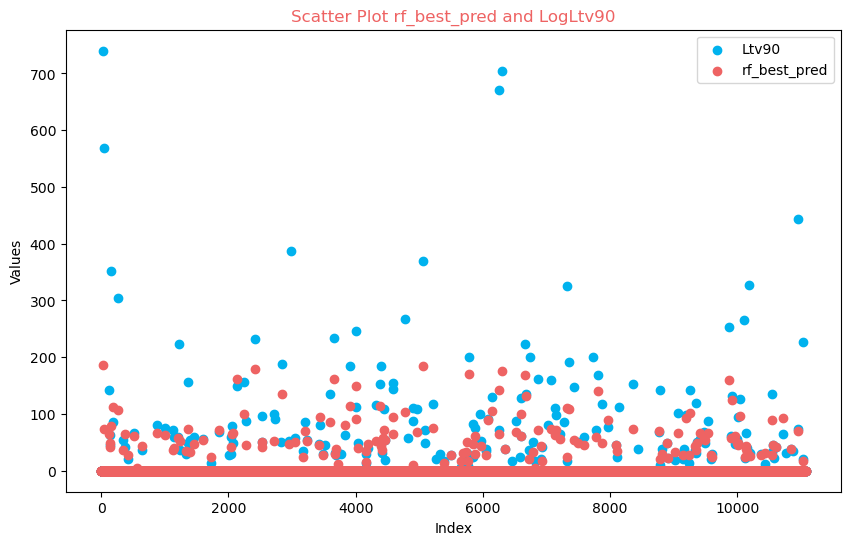

In [72]:
plt.figure(figsize=(10, 6))
plt.scatter(rf_best_comb.index, rf_best_comb['Ltv90'],color='#00b2ee', label='Ltv90')
plt.scatter(rf_best_comb.index, rf_best_comb['rf_best_pred'], color='#ee6363', label='rf_best_pred')
plt.title('Scatter Plot rf_best_pred and LogLtv90', color = '#ee6363')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

## Ridge için Tahminler

In [104]:
ridge_pred = pd.DataFrame(ridge_model_ss.predict(x_ss_test), columns = ['ridge_pred'])
y_test_df = pd.DataFrame(y_test).reset_index(drop = True)
ridge_comb = pd.concat([ridge_pred,y_test_df], axis = 1)
ridge_comb['ridge_pred'] = np.exp(ridge_comb['ridge_pred'] )
ridge_comb['Ltv90'] = np.exp(ridge_comb['LogLtv90'] )
pd.set_option('display.float_format', lambda x: '%.4f' % x)
ridge_comb.sample(9)

C:\Users\w11\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


,ridge_pred,LogLtv90,Ltv90
6190,0.0000,-23.0259,0.0000
1596,0.0000,-23.0259,0.0000
571,0.0000,-23.0259,0.0000
4263,0.0000,-23.0259,0.0000
10254,0.0000,-23.0259,0.0000
8882,0.0000,-23.0259,0.0000
4910,0.0000,-23.0259,0.0000
6957,0.0000,-23.0259,0.0000
1586,0.0000,-23.0259,0.0000


In [105]:
ridge_comb[(ridge_comb['ridge_pred']>1) & (ridge_comb['ridge_pred']<500)]

,ridge_pred,LogLtv90,Ltv90
186,1.6722,4.4543,86.0000
267,26.8265,5.7203,305.0000
1126,1.7807,4.2627,71.0000
1363,3.1794,5.0562,157.0000
1601,3.8228,4.0254,56.0000
2066,21.7061,3.8918,49.0000
2137,51.6449,5.0106,150.0000
2270,87.7223,4.4659,87.0000
2411,10.9012,5.4467,232.0000
2535,22.1168,3.9318,51.0000


In [113]:
ridge_comb1 = ridge_comb[(ridge_comb['ridge_pred']<500)]

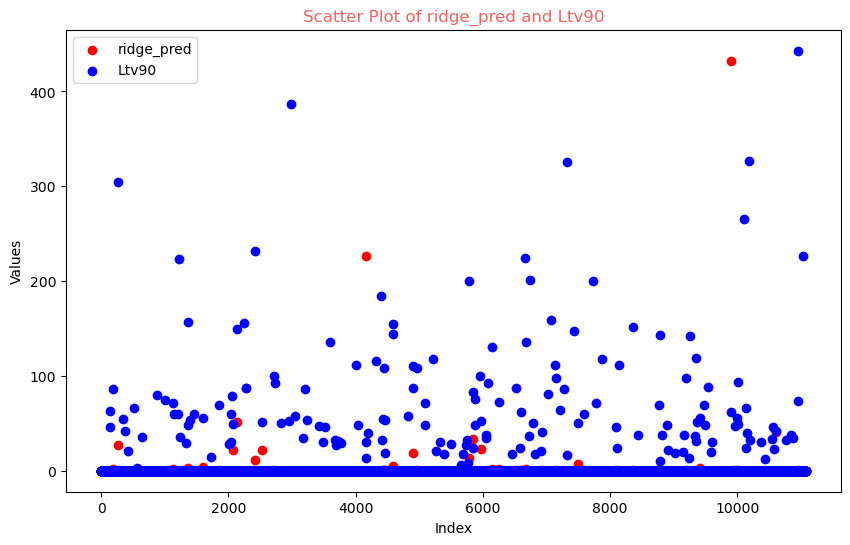

In [114]:
plt.figure(figsize=(10, 6))
plt.scatter(ridge_comb1.index, ridge_comb1['ridge_pred'], color='red', label='ridge_pred')
plt.scatter(ridge_comb1.index, ridge_comb1['Ltv90'], color='blue', label='Ltv90')
plt.title('Scatter Plot of ridge_pred and Ltv90', color = '#ee6363')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

In [76]:
test_score = ridge_model_ss.score(x_ss_test, y_test)
mae = mean_absolute_error(y_test, ridge_pred)
mse = mean_squared_error(y_test, ridge_pred)
rmse = np.sqrt(mse)
Train_score = r2_score(y_train, ridge_model_ss.predict(X_ss))


print('Test R2 Score:', round(test_score,3))
print(f"Train R² Score: {Train_score:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")

Test R2 Score: 0.668
Train R² Score: 0.670
Mean Absolute Error: 0.491
Mean Squared Error: 4.361
Root Mean Squared Error: 2.088


C:\Users\w11\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


# Save Models As Pickle which is going to used on api

In [77]:
dump(rf_model_best, 'randomForestBestModel.pkl')

['randomForestBestModel.pkl']

In [78]:
merged_df.to_pickle('merged_df.pkl')

In [79]:
dump(rf_model, 'randomForest100Model_new.pkl')

['randomForest100Model_new.pkl']